# Siamese Networks with Triple Loss on MNIST dataset

#### prerequisites

In [ ]:
!pip install -U tensorflow-addons


Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.6/dist-packages (0.12.1)


#### Import

In [ ]:
# general
import numpy as np
import pandas as pd

# logic
from sklearn.decomposition import PCA

# visual
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# tf
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# deep 
import tensorflow.keras as k
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Layer, Lambda


#### channels last

In [ ]:
assert k.backend.image_data_format() == 'channels_last' 

# Dataset

### Download 

In [ ]:
BATCH_SIZE = 64
(x_train, y_train), (x_test, y_test) = k.datasets.mnist.load_data()

In [ ]:
(ds_train, ds_test) = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


In [ ]:
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(buffer_size=1000)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

### Sample

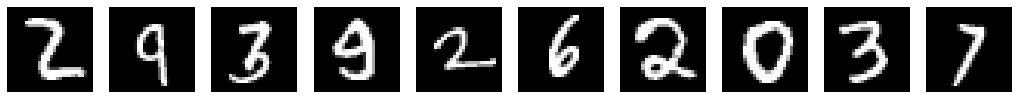

In [ ]:
n_images = 10
f, axarr = plt.subplots(1,n_images,figsize=(18,8)) 

for ax,img in zip(axarr,ds_train.as_numpy_iterator().next()[0][0:n_images]):
  ax.imshow(img.squeeze(),cmap='gray')
  ax.axis('off')

### Distribution

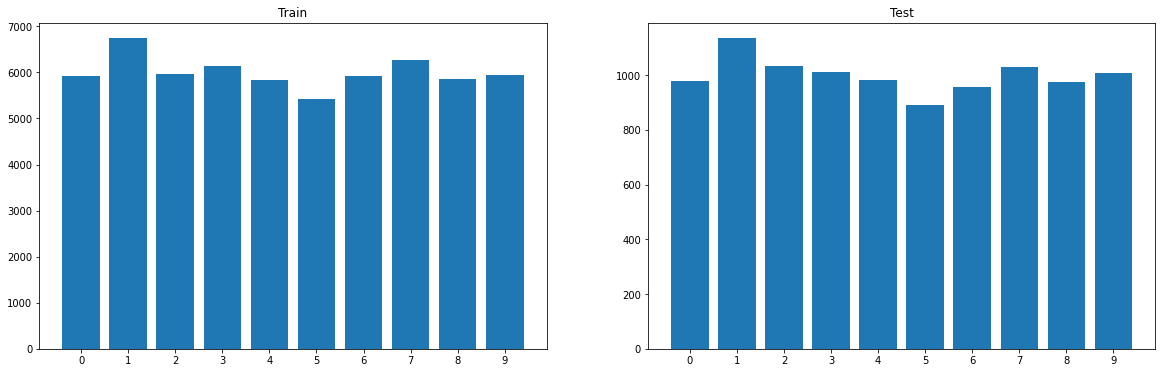

In [ ]:
train_labels = np.concatenate([y for x, y in ds_train], axis=0)
test_labels = np.concatenate([y for x, y in ds_test], axis=0)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
labels, counts = np.unique(train_labels, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Train')


plt.subplot(1,2,2)
labels, counts = np.unique(test_labels, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Test');

# Model

### Inner Network

In [ ]:
n_classes = 10

reg = l2(1e-3) 
input_shape = (28,28,1)

inner_model = Sequential(name='inner_model')

inner_model.add(Input(shape=input_shape))

inner_model.add(Conv2D(filters=256,kernel_size=3,activation='relu',kernel_regularizer=reg))
inner_model.add(MaxPooling2D())

inner_model.add(Conv2D(filters=128,kernel_size=3,activation='relu',kernel_regularizer=reg))
inner_model.add(MaxPooling2D())

inner_model.add(Conv2D(filters=64,kernel_size=3,activation='relu',kernel_regularizer=reg))
inner_model.add(MaxPooling2D())

inner_model.add(Flatten())
inner_model.add(Dense(1024, activation='relu',kernel_regularizer=reg))
inner_model.add(Dense(n_classes, activation=None,kernel_regularizer=reg))

In [ ]:
model = Sequential(name='l2_model')

model.add(Input(shape=input_shape))

model.add(Conv2D(filters=256,kernel_size=3,activation='relu',kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128,kernel_size=3,activation='relu',kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64,kernel_size=3,activation='relu',kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024, activation='relu',kernel_regularizer=reg))
model.add(Dense(n_classes, activation=None,kernel_regularizer=reg))

# L2 normalize embeddings - WHY???? must?
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))

In [ ]:
# display
# inner_model.summary()
# inner_model(model,show_shapes=True, show_layer_names=True)

# display
# inner_model.summary()
# inner_model(model,show_shapes=True, show_layer_names=True)

### Train

In [ ]:
inner_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())
history_inner_model = inner_model.fit(ds_train, epochs=5)

Epoch 1/5
938/938 [==============================] - 7s 4ms/step - loss: 0.4995
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2623
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2276
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2070
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1942


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())
history_model = model.fit(ds_train,epochs=5)

Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.7496
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.3362
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2658
Epoch 4/5
938/938 [==============================] - 4s 5ms/step - loss: 0.2479
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2318


# Visualize Results

(10000, 10)

In [ ]:
results = inner_model.predict(ds_test,batch_size=BATCH_SIZE)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(results)
a  = pd.DataFrame({'x':pca_results[:,0], 'y':pca_results[:,1] , 'z':test_labels})

print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [0.32881927 0.21301116]


In [ ]:
results = model.predict(ds_test,batch_size=BATCH_SIZE)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(results)
b  = pd.DataFrame({'x':pca_results[:,0], 'y':pca_results[:,1] , 'z':test_labels})

print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [0.1503842  0.13543025]


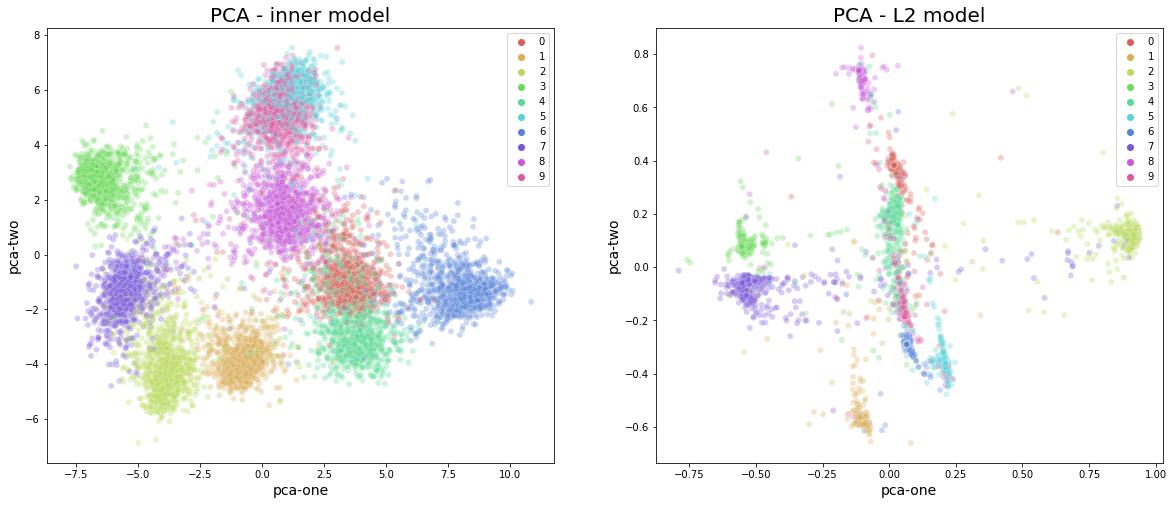

In [ ]:
plt.figure(figsize=(20,8))


def display_pca(num_plot,title,data):
  
  plt.subplot(1,2,num_plot)
  sns.scatterplot(
      x='x', y='y',
      hue='z',
      palette=sns.color_palette("hls", 10),
      data=data,
      legend="full",
      alpha=0.3,
  )
  plt.legend(loc='upper right')
  plt.title(title, fontsize=20)
  plt.xlabel("pca-one", fontsize=14)
  plt.ylabel("pca-two", fontsize=14)
  ;

display_pca(1,'PCA - inner model',a)
display_pca(2,'PCA - L2 model',b)

In [ ]:
a.shape,b.shape

((10000, 3), (10000, 3))